**Imports**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import coco
import yolo
import vgg

**Configuration**

In [2]:
repo_dir = project_name = 'COTSDataset' 
part1_single_objects = os.path.join(repo_dir, "Part 1 - Single Objects")
part2_multiple_objects = os.path.join(repo_dir, "Part 2 - Multiple Objects")
part3_complex_background = os.path.join(repo_dir, "Part 3 - Complex Background")

In [3]:
do_display = True
do_save = False
do_print = False

# COCO
coco_output_dir = "COCO_annotations"
coco_color = (0, 255, 0)

# YOLO
yolo_output_dir = "YOLO_annotations"
yolo_color = (0, 255, 0)

# VGG
vgg_output_dir = "VGG_annotations"
vgg_color = 'r'

In [4]:
annotation = cv2.imread('COTSDataset/Part 2 - Multiple Objects/academic_book_no/masks/ac_3_colour_mask_7_mask.png')
annotation = cv2.cvtColor(annotation, cv2.COLOR_BGR2RGB)
annotation = coco.annotate((0, 0, annotation, project_name, 0, coco_output_dir),
                        do_display=False, do_save=False, do_print=False, annotation_color=coco_color, epsilon=0)

**Intersection of Union**

In [5]:
def iou(annotation):
    gt = annotation['image'][:, :, 0] > 0
    annotation_mask = np.zeros((annotation['height'], annotation['width']), dtype=np.uint8)
    cv2.drawContours(annotation_mask, annotation['contours'], -1, 255, -1)
    # resize annotation mask to gt size
    annotation_mask = cv2.resize(annotation_mask, (gt.shape[1], gt.shape[0]))

    # plot both on each other transparently, one blue one red
    # plt.figure()
    # plt.rcParams['figure.figsize'] = [20, 10]
    # plt.imshow(gt, cmap='Blues', alpha=0.5)
    # plt.imshow(annotation_mask, cmap='Reds', alpha=0.5)
    # plt.xticks([])
    # plt.yticks([])
    # plt.show()

    intersection = np.logical_and(gt, annotation_mask)
    union = np.logical_or(gt, annotation_mask)
    return np.sum(intersection) / np.sum(union)

In [6]:
iou(annotation)

0.9705764668895939

**Find the optimal value of $ε$**

In [7]:
image_id = 0

iou_sum = 0
count = 0

epsilon_tests = np.arange(0, 0.05, 0.0001)
epsilon_results = {}
medians = []

for epsilon in epsilon_tests:
    ious = []

    for image_paths in os.listdir(part2_multiple_objects):
        mask_paths = os.path.join(part2_multiple_objects, image_paths, "masks")
        category = image_paths
        for mask_name in os.listdir(mask_paths):
            image = cv2.imread(os.path.join(mask_paths, mask_name))
            annotation = coco.annotate((image_id, mask_name, image, project_name, category, coco_output_dir),
                        do_display=False, do_save=False, do_print=False, annotation_color=coco_color, epsilon=epsilon)

            # print(f'{mask_name}: {mse(annotation)}')
            image_id += 1
            iou_sum += iou(annotation)
            count += 1

            ious.append(iou(annotation))

    epsilon_results[epsilon] = iou_sum / count
    median = np.median(ious)
    medians.append(median)

    iou_sum = 0
    count = 0

    print(f'epsilon: {epsilon}, iou: {epsilon_results[epsilon]}, median: {median}')

epsilon: 0.0, iou: 0.9456204721196075, median: 0.9525001173284864
epsilon: 0.0001, iou: 0.9456204721196075, median: 0.9525001173284864
epsilon: 0.0002, iou: 0.9456204721196075, median: 0.9525001173284864


KeyboardInterrupt: 

In [ ]:
# find largest iou
max_iou = max(epsilon_results.values())
max_iou_epsilon = [k for k, v in epsilon_results.items() if v == max_iou][0]

# find largest median
max_median = max(medians)
max_median_epsilon = epsilon_tests[medians.index(max_median)]

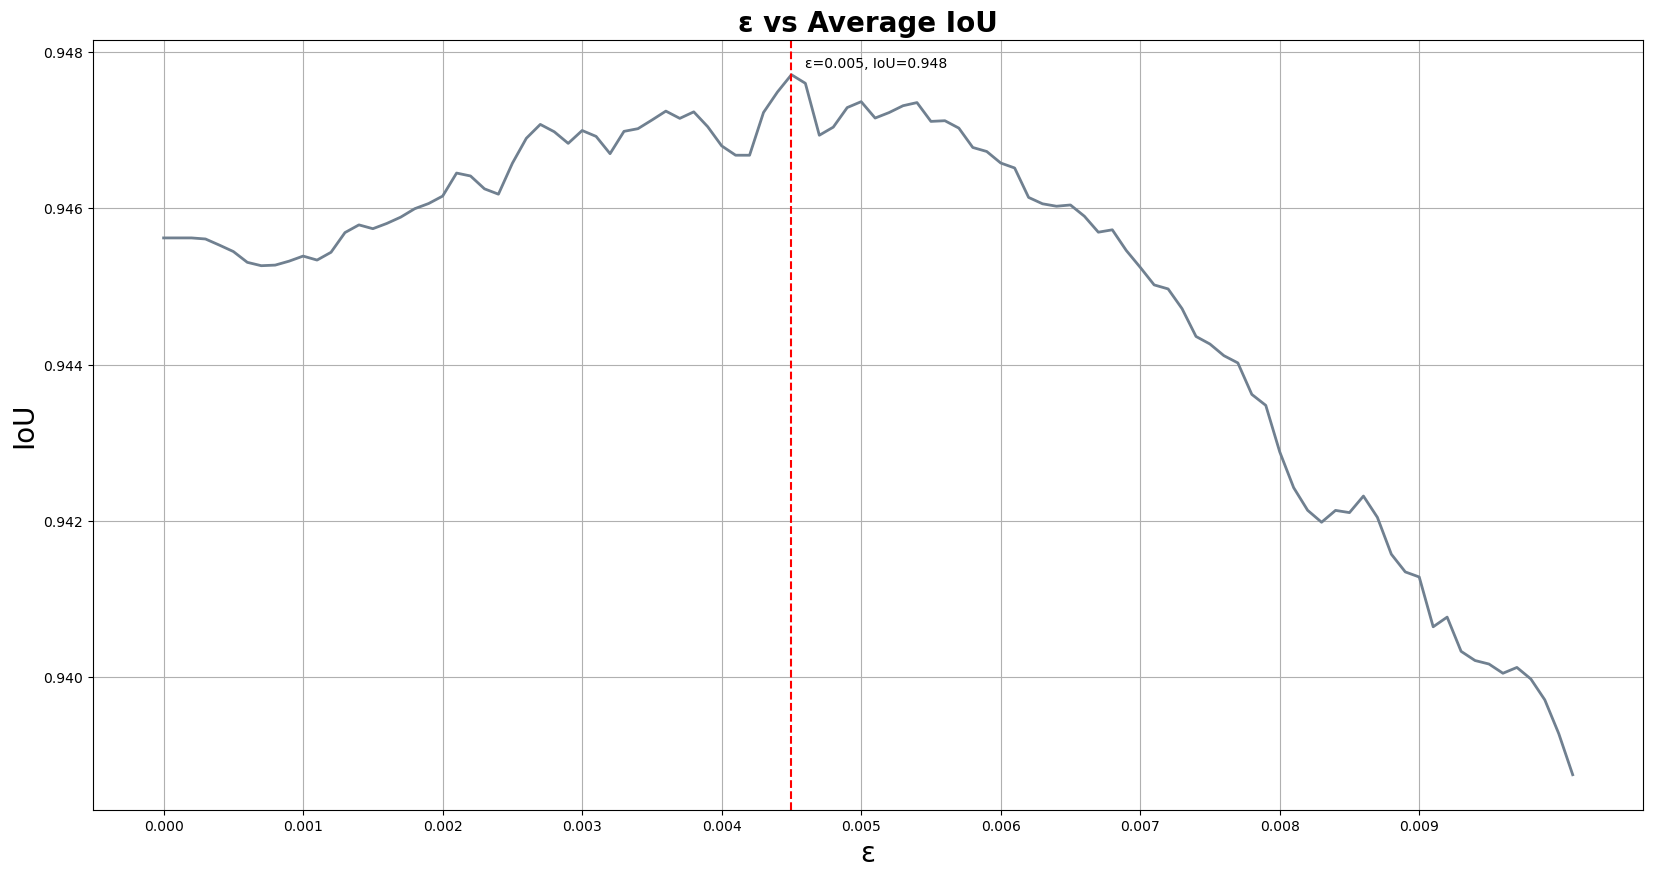

In [ ]:
# plot epsilon results
plt.rcParams['figure.figsize'] = [20, 10]
plt.figure()
# black plot line
plt.plot(epsilon_results.keys(), epsilon_results.values(), color='slategrey', linewidth=2)


# print vertical line where max iou is
plt.axvline(x=max_iou_epsilon, color='r', linestyle='--')

# print max iou
plt.text(max_iou_epsilon + 0.0001, max_iou + 0.0001, f'ε={max_iou_epsilon:.3f}, IoU={max_iou:.3f}')

plt.xlabel('ε', fontsize=20)
plt.ylabel('IoU', fontsize=20)
plt.title('ε vs Average IoU', fontsize=20, fontweight='bold')
plt.xticks(np.arange(0, 0.01, 0.001))
plt.grid()
plt.show()

**IoU across all images in COTS (Polygon Approximation)**

In [24]:
image_id = 0

epsilon = 0.005

pa_ious = []

for image_paths in os.listdir(part2_multiple_objects):
    mask_paths = os.path.join(part2_multiple_objects, image_paths, "masks")
    category = image_paths
    for mask_name in os.listdir(mask_paths):
        image = cv2.imread(os.path.join(mask_paths, mask_name))
        annotation = coco.annotate((image_id, mask_name, image, project_name, category, coco_output_dir),
                    do_display=False, do_save=False, do_print=False, annotation_color=coco_color, epsilon=epsilon, configuration=coco.PA)

        # print(f'{mask_name}: {mse(annotation)}')
        image_id += 1
        pa_ious.append([mask_name, iou(annotation)])

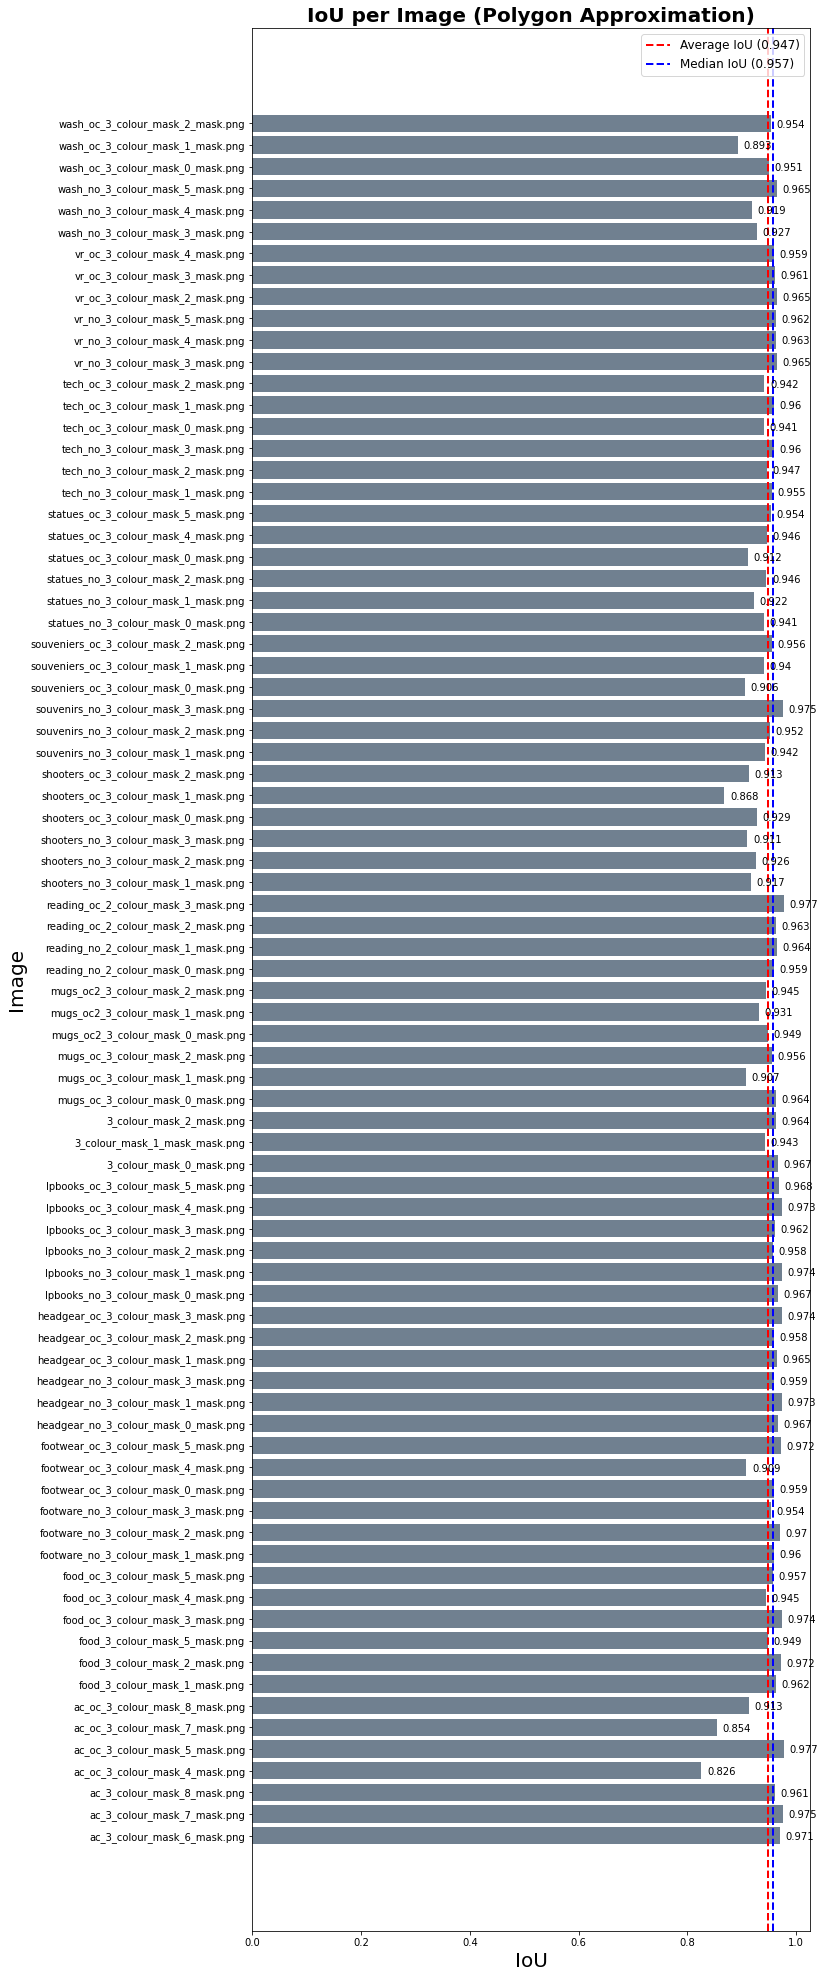

In [25]:
# Plot bar chart of ious, image on y axis, iou on x axis
plt.rcParams['figure.figsize'] = [10, 35]
plt.figure()

# sort ious descending
# ious.sort(key=lambda x: x[1], reverse=True)
plt.barh(np.arange(len(pa_ious)), [x[1] for x in pa_ious], align='center', color='slategrey')

# print values on bars on the right
for i, v in enumerate([x[1] for x in pa_ious]):
    plt.text(v + 0.01, i - 0.2, str(round(v, 3)), color='k', fontsize=10)

# add image names to y axis
plt.yticks(np.arange(len(pa_ious)), [x[0] for x in pa_ious], fontsize=10)

# plot vertical line at average and median
plt.axvline(x=np.mean([x[1] for x in pa_ious]), color='r', linestyle='--', linewidth=2)
plt.axvline(x=np.median([x[1] for x in pa_ious]), color='b', linestyle='--', linewidth=2)

# add legend
average_legend = 'Average IoU (' + str(np.round(np.mean([x[1] for x in pa_ious]), 3)) + ')'
median_legend = 'Median IoU (' + str(np.round(np.median([x[1] for x in pa_ious]), 3)) + ')'
plt.legend([average_legend, median_legend], loc='upper right', fontsize=12)

plt.xlabel('IoU', fontsize=20)
plt.ylabel('Image', fontsize=20)
plt.title('IoU per Image (Polygon Approximation)', fontsize=20, fontweight='bold')

plt.show()

**IoU across all images in COCO**

**Segment-anything**


In [13]:
# Dependencies required for segment-anything
# %pip install git+https://github.com/facebookresearch/segment-anything.git
# %pip install torch torchvision
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Segment-anything model
# Downloading model checkpoint:
# Utilise the following link: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
# Place the downloaded checkpoint in a new directory named Sam_checkpoints
sam_checkpoint = "Sam_checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam)

KeyError: '<model_type>'

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [12]:
image=cv2.imread('COTSDataset/Part 2 - Multiple Objects/academic_book_no/masks/ac_3_colour_mask_7_mask.png')

masks = mask_generator.generate(image)
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

NameError: name 'predictor' is not defined

**Clustering**


**IoU across all images in COTS (K-Means Clustering)**

In [27]:
image_id = 0

# epsilon = 0.005

kmeans_ious = []

for image_paths in os.listdir(part2_multiple_objects):
    mask_paths = os.path.join(part2_multiple_objects, image_paths, "masks")
    category = image_paths
    for mask_name in os.listdir(mask_paths):
        image = cv2.imread(os.path.join(mask_paths, mask_name))
        annotation = coco.annotate((image_id, mask_name, image, project_name, category, coco_output_dir),
                    do_display=False, do_save=False, do_print=False, annotation_color=coco_color, configuration=coco.KMC)

        # print(f'{mask_name}: {mse(annotation)}')
        image_id += 1
        kmeans_ious.append([mask_name, iou(annotation)])

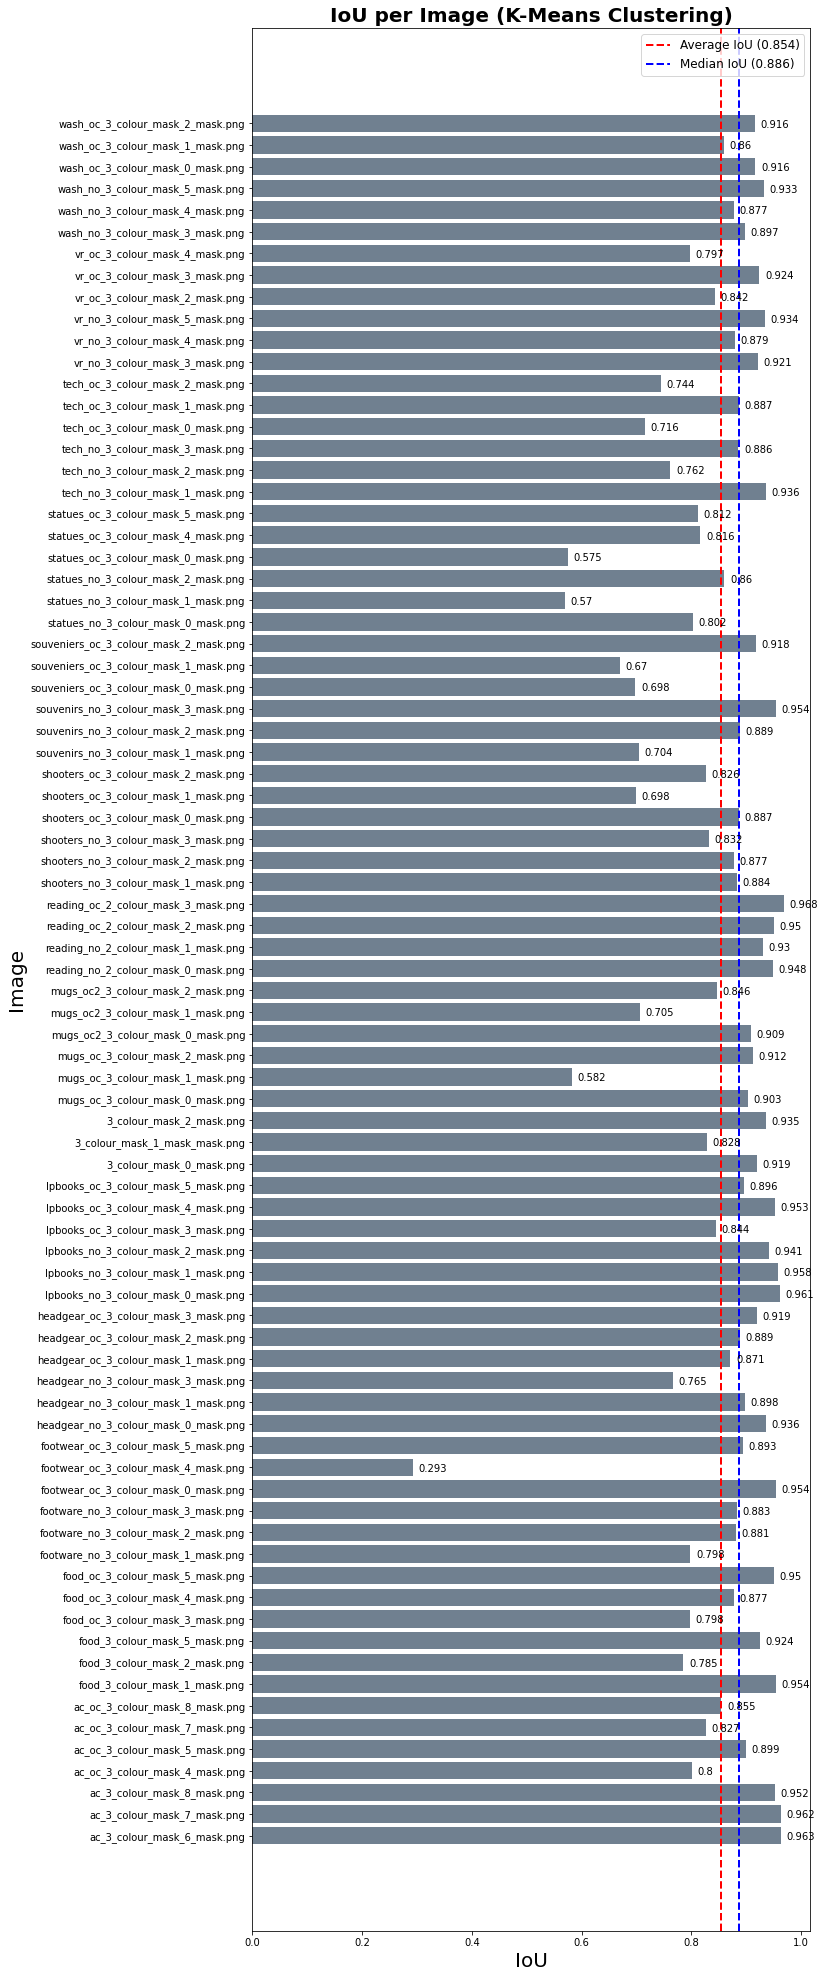

In [28]:
# Plot bar chart of ious, image on y axis, iou on x axis
plt.rcParams['figure.figsize'] = [10, 35]
plt.figure()

# sort ious descending
# ious.sort(key=lambda x: x[1], reverse=True)
plt.barh(np.arange(len(kmeans_ious)), [x[1] for x in kmeans_ious], align='center', color='slategrey')

# print values on bars on the right
for i, v in enumerate([x[1] for x in kmeans_ious]):
    plt.text(v + 0.01, i - 0.2, str(round(v, 3)), color='k', fontsize=10)

# add image names to y axis
plt.yticks(np.arange(len(kmeans_ious)), [x[0] for x in kmeans_ious], fontsize=10)

# plot vertical line at average and median
plt.axvline(x=np.mean([x[1] for x in kmeans_ious]), color='r', linestyle='--', linewidth=2)
plt.axvline(x=np.median([x[1] for x in kmeans_ious]), color='b', linestyle='--', linewidth=2)

# add legend
average_legend = 'Average IoU (' + str(np.round(np.mean([x[1] for x in kmeans_ious]), 3)) + ')'
median_legend = 'Median IoU (' + str(np.round(np.median([x[1] for x in kmeans_ious]), 3)) + ')'
plt.legend([average_legend, median_legend], loc='upper right', fontsize=12)

plt.xlabel('IoU', fontsize=20)
plt.ylabel('Image', fontsize=20)
plt.title('IoU per Image (K-Means Clustering)', fontsize=20, fontweight='bold')

plt.show()

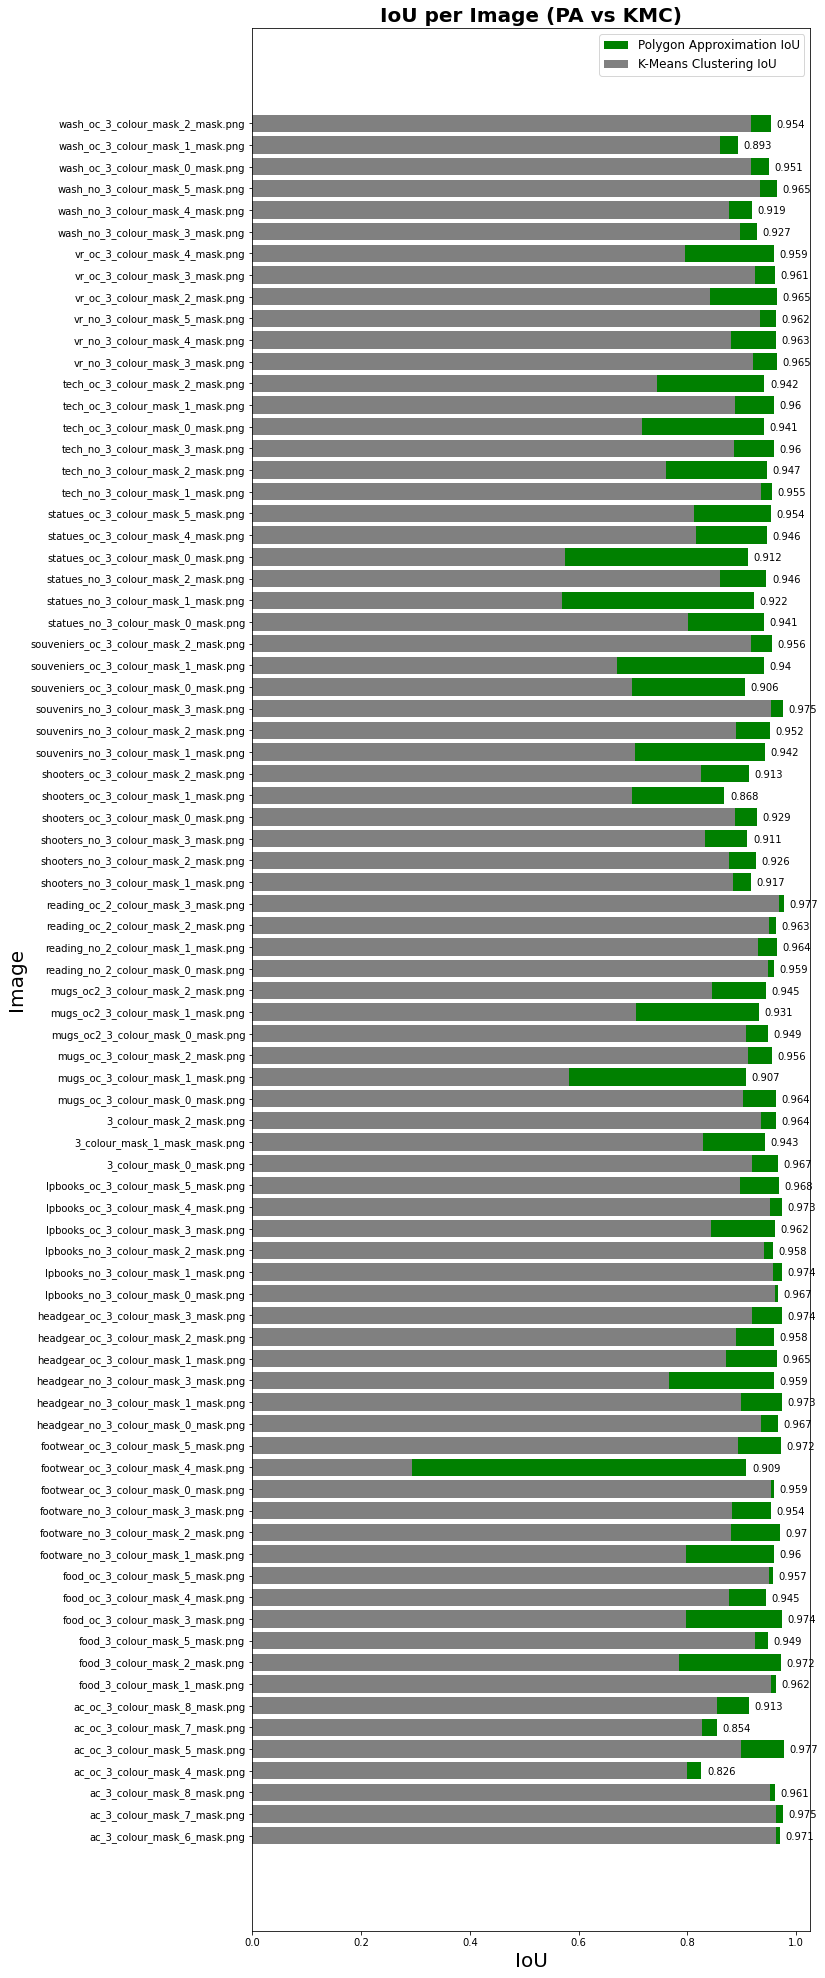

In [55]:
# Plot bar chart of ious, image on y axis, iou on x axis
plt.rcParams['figure.figsize'] = [10, 35]
plt.figure()

# print both ious on same bar chart
plt.barh(np.arange(len(kmeans_ious)), [x[1] for x in pa_ious], align='center', color='green')
plt.barh(np.arange(len(kmeans_ious)), [x[1] for x in kmeans_ious], align='center', color='grey')

# print values on bars on the right
for i, v in enumerate([x[1] for x in pa_ious]):
    plt.text(v + 0.01, i - 0.2, str(round(v, 3)), color='k', fontsize=10)

# add image names to y axis
plt.yticks(np.arange(len(kmeans_ious)), [x[0] for x in kmeans_ious], fontsize=10)

# plot vertical line at average and median
# plt.axvline(x=np.mean([x[1] for x in kmeans_ious]), color='r', linestyle='--', linewidth=2)
# plt.axvline(x=np.median([x[1] for x in kmeans_ious]), color='b', linestyle='--', linewidth=2)

# add legend
pa_legend = 'Polygon Approximation IoU'
kmeans_legend = 'K-Means Clustering IoU'
plt.legend([pa_legend, kmeans_legend], loc='upper right', fontsize=12)

plt.xlabel('IoU', fontsize=20)
plt.ylabel('Image', fontsize=20)
plt.title('IoU per Image (PA vs KMC)', fontsize=20, fontweight='bold')

plt.show()

In [ ]:
# compactness
def compactness(annotation):
    # area of annotation
    area = annotation['image'].shape[0] * annotation['image'].shape[1]

    # perimeter of annotation
    perimeter = 0
    for contour in annotation['contours']:
        perimeter += cv2.arcLength(contour, True)

    return (perimeter ** 2) / area